In [15]:
# Import packages
import datetime
import geopandas as gpd
import holidays
# import july
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
from dbfread import DBF
# import seaborn as sns
import shutil
import time
# Import CEA modules
import cea.config
import cea.api 
from cea.utilities.dbf import *
from cea.utilities.epwreader import epw_reader
from cea.datamanagement.archetypes_mapper import archetypes_mapper
from cea.demand.schedule_maker.schedule_maker import main as schedule_maker
from cea.demand.demand_main import main as demand_main
from cea.resources.radiation.main import main as radiation_main


DAYSIM_BIN_DIRECTORY = os.path.join(os.getcwd(), 'CEA_model/0_daysim_binaries/darwin')
project_folder = os.path.join(os.getcwd(), 'CEA_model')


zone_gdf = gpd.read_file(
    os.path.join(project_folder, 'Mierendorff_full', '2020', 'inputs', 'building-geometry', 'zone.shp')) 
list_buildings = zone_gdf["Name"].tolist() 

selection_gdf = zone_gdf.copy()
selection_gdf


,Name,height_ag,floors_ag,height_bg,floors_bg,descriptio,category,REFERENCE,house_no,street,postcode,house_name,resi_type,city,country,geometry
0,B1000,2.0,2,3.0,1,NaN,school,OSM - as it is,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((384874.043 5820594.084, 384873.807 5..."
1,B1001,3.0,3,3.0,1,NaN,service,OSM - as it is,10,Lise-Meitner-Straße,10589,NaN,NaN,Berlin,DE,"POLYGON ((385147.715 5821181.978, 385145.006 5..."
2,B1002,1.0,1,3.0,1,NaN,yes,OSM - as it is,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((385315.603 5820595.263, 385265.770 5..."
3,B1003,1.0,1,3.0,1,NaN,yes,OSM - as it is,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((385231.453 5820685.213, 385230.993 5..."
4,B1004,6.0,6,3.0,1,NaN,apartments,OSM - as it is,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((385092.809 5820650.440, 385096.097 5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,B2090,6.0,6,3.0,1,NaN,apartments,OSM - as it is,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((384534.446 5821185.198, 384551.996 5..."
1091,B2091,7.0,7,3.0,1,NaN,office,OSM - as it is,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((384496.173 5821441.148, 384483.113 5..."
1092,B2092,6.0,6,3.0,1,NaN,apartments,OSM - as it is,21,Mierendorffstraße,10589,NaN,NaN,Berlin,DE,"POLYGON ((384788.185 5820672.254, 384786.705 5..."
1093,B2093,6.0,6,3.0,1,NaN,apartments,OSM - as it is,23,Mierendorffstraße,10589,NaN,NaN,Berlin,DE,"POLYGON ((384799.372 5820694.503, 384795.628 5..."


In [17]:
# drop everything that is smaller than 40m2  
selection_gdf["area"] = selection_gdf["geometry"].area
buildings_above_40sqm = selection_gdf.query('area> 40')["Name"]

In [22]:
# adjust type on main type for block 
# first check if there is an overlap 
import os 
dir_path = os.getcwd()
shape_data_path = os.path.join(dir_path, 'auxillary',  '00_block_shape.shp')
shapes = gpd.read_file(shape_data_path)
shapes["blknr"] = shapes["blknr"].astype('int64') 
file_path_age = os.path.join(dir_path, 'auxillary','02_Gebäudealter.csv') 
age_df = pd.read_csv(file_path_age)
bldg_age_shapes =  shapes.merge(age_df, on='blknr') 

In [26]:
zone_gdf["geometry"].intersects(bldg_age_shapes["geometry"], align=True)



False    1095
Name: count, dtype: int64

In [40]:
list(zone_gdf["category"].value_counts().index)

['yes',
 'apartments',
 'allotment_house',
 'residential',
 'bungalow',
 'industrial',
 'roof',
 'office',
 'commercial',
 'silo',
 'retail',
 'hut',
 'warehouse',
 'service',
 'school',
 'public',
 'garages',
 'church',
 'electricity',
 'house',
 'garage',
 'construction',
 'manufacture',
 'kindergarten',
 'bridge',
 'toilets',
 'sports_hall',
 'train_station',
 'shed',
 'detached',
 'houseboat']

# Archetye mapping

Drop houseboat, detached, shed, train_station, toilets, bridge, construction, garage (s), hut, allotment_house, bungalow, church (?), roof, silo, electricity

Assume yes is apparment. 

Compare with: https://wiki.openstreetmap.org/wiki/Key:building 

In [51]:
bldg_to_drop = ["houseboat", "detached", "shed", "train_station", "toilets", "bridge", "construction", "garage", "garages", "hut", "allotment_house", "bungalow", "church", "roof", "silo", "electricity"]

In [52]:
bldg_type_list = [x for x in list(zone_gdf["category"].value_counts().index) if x not in bldg_to_drop]
bldg_type_list

['yes',
 'apartments',
 'residential',
 'industrial',
 'office',
 'commercial',
 'retail',
 'warehouse',
 'service',
 'school',
 'public',
 'house',
 'manufacture',
 'kindergarten',
 'sports_hall']

In [57]:
ARCHETYPES = {
     "apartments": {
        "1860-1918": "AB_B",
        "1919-1948": "AB_C",
        "1949-1957": "AB_D",
        "1958-1968": "AB_E",
        "1969-1978": "AB_F",
    },
    "residential": {
        "1860-1918": "AB_B",
        "1919-1948": "AB_C",
        "1949-1957": "AB_D",
        "1958-1968": "AB_E",
        "1969-1978": "AB_F",
    },
      "yes": {
        "1860-1918": "AB_B",
        "1919-1948": "AB_C",
        "1949-1957": "AB_D",
        "1958-1968": "AB_E",
        "1969-1978": "AB_F",
    },
    "industrial": {
        "1860-1978": "NWG_G2_A",
        "1979-2009": "NWG_G2_B",
        "2010-2030": "NWG_G2_C",
    }, 

    "office": {
        "1860-1978": "NWG_1_A",
        "1979-2009": "NWG_1_B",
        "2010-2030": "NWG_1_C",
    },
      "commercial": {
        "1860-1978": "NWG_G1_A",
        "1979-2009": "NWG_G1_B",
        "2010-2030": "NWG_G1_C",
    }, 
    "retail" : {
        "1860-1978": "NWG_G1_A",
        "1979-2009": "NWG_G1_B",
        "2010-2030": "NWG_G1_C",
    }, 
    "warehouse": {
        "1860-1978": "NWG_8_A",
        "1979-2009": "NWG_8_B",
        "2010-2030": "NWG_8_C",
    }, 
        "service" : {
             "1860-1978": "NWG_10_A",
        "1979-2009": "NWG_10_B",
        "2010-2030": "NWG_10_C",
        },
        "school": {
        "1860-1978": "NWG_4_A",
        "1979-2009": "NWG_4_B",
        "2010-2030": "NWG_4_C",
    },
    "public": {
           "1860-1978": "NWG_5_A",
        "1979-2009": "NWG_5_B",
        "2010-2030": "NWG_5_C",
    }, 
    "house": {
        "1860-1918": "AB_B",
        "1919-1948": "AB_C",
        "1949-1957": "AB_D",
        "1958-1968": "AB_E",
        "1969-1978": "AB_F",
    },"manufacture" : {
        "1860-1978": "NWG_8_A",
        "1979-2009": "NWG_8_B",
        "2010-2030": "NWG_8_C",
    }, 
    
        "kindergarten": {
        "1860-1978": "NWG_4_A",
        "1979-2009": "NWG_4_B",
        "2010-2030": "NWG_4_C",
    }, 
    "sports_hall": {
        "1860-1978": "NWG_6_A",
        "1979-2009": "NWG_6_B",
        "2010-2030": "NWG_6_C",
    }}



In [103]:
print(ARCHETYPES.keys())

dict_keys(['apartments', 'residential', 'yes', 'industrial', 'office', 'commercial', 'retail', 'warehouse', 'service', 'school', 'public', 'house', 'manufacture', 'kindergarten', 'sports_hall'])


In [27]:
gpd.overlay(zone_gdf, bldg_age_shapes, how='intersection')

,Name,height_ag,floors_ag,height_bg,floors_bg,descriptio,category,REFERENCE,house_no,street,...,x1961_1970,x1971_1980,x1981_1990,x1991_2000,x2001_2010,x2011_2015,ew2015,typ,typklar,geometry
0,B1000,2.0,2,3.0,1,NaN,school,OSM - as it is,NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,NaN,479.0,13.0,Neubau-Schule (nach 1945),"POLYGON ((384873.807 5820581.426, 384886.006 5..."
1,B1024,1.0,1,3.0,1,NaN,sports_hall,OSM - as it is,29,Sömmeringstraße,...,NaN,1.0,1.0,NaN,NaN,NaN,479.0,13.0,Neubau-Schule (nach 1945),"POLYGON ((385043.932 5820642.061, 385043.749 5..."
2,B1026,4.0,4,3.0,1,NaN,public,OSM - as it is,30,Mierendorffstraße,...,NaN,1.0,1.0,NaN,NaN,NaN,479.0,13.0,Neubau-Schule (nach 1945),"POLYGON ((384922.724 5820735.592, 384929.001 5..."
3,B1135,6.0,6,3.0,1,NaN,apartments,OSM - as it is,NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,NaN,479.0,13.0,Neubau-Schule (nach 1945),"POLYGON ((385030.143 5820713.906, 385029.951 5..."
4,B1143,3.0,3,3.0,1,NaN,yes,OSM - as it is,22,Nordhauser Straße,...,NaN,1.0,1.0,NaN,NaN,NaN,479.0,13.0,Neubau-Schule (nach 1945),"POLYGON ((384966.057 5820720.330, 384966.311 5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1691,B2082,6.0,6,3.0,1,NaN,residential,OSM - as it is,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,300.0,10.0,Blockrandbebauung mit Großhöfen (1920er-1940er...,"POLYGON ((385451.043 5820715.937, 385446.869 5..."
1692,B2083,5.0,5,3.0,1,NaN,apartments,OSM - as it is,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,323.0,10.0,Blockrandbebauung mit Großhöfen (1920er-1940er...,"POLYGON ((384649.990 5821130.060, 384649.766 5..."
1693,B2084,6.0,6,3.0,1,NaN,apartments,OSM - as it is,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,691.0,10.0,Blockrandbebauung mit Großhöfen (1920er-1940er...,"POLYGON ((384620.571 5821059.758, 384631.713 5..."
1694,B2085,6.0,6,3.0,1,NaN,apartments,OSM - as it is,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,691.0,10.0,Blockrandbebauung mit Großhöfen (1920er-1940er...,"POLYGON ((384622.619 5821008.006, 384622.870 5..."


In [66]:
def merge_with_max_overlap(gdf_buildings, gdf_blocks):
    # Initialize an empty list to store the result data
    results = []

    # Iterate over each polygon in gdf_buildings
    for index_a, row_a in gdf_buildings.iterrows():
        max_overlap = 0
        best_match = None

        # Compute intersection with each polygon in gdf_blocks and find the max overlap
        for index_b, row_b in gdf_blocks.iterrows():
            intersection = row_a['geometry'].intersection(row_b['geometry'])
            overlap_area = intersection.area

            if overlap_area > max_overlap:
                max_overlap = overlap_area
                best_match = row_b

        # Create a new record for the resulting GeoDataFrame
        if best_match is not None:
            merged_attrs = {**row_a.to_dict(), **best_match.to_dict(), 'overlap_area': max_overlap}
            results.append(merged_attrs)

    # Convert the list of dicts to a GeoDataFrame
    result_gdf = gpd.GeoDataFrame(results, crs=zone_gdf.crs)

    return result_gdf


overlap = merge_with_max_overlap(zone_gdf, bldg_age_shapes)

overlap.head()

,Name,height_ag,floors_ag,height_bg,floors_bg,descriptio,category,REFERENCE,house_no,street,...,x1961_1970,x1971_1980,x1981_1990,x1991_2000,x2001_2010,x2011_2015,ew2015,typ,typklar,overlap_area
0,B1000,2.0,2,3.0,1,NaN,school,OSM - as it is,NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,NaN,479.0,13.0,Neubau-Schule (nach 1945),2526.631853
1,B1001,3.0,3,3.0,1,NaN,service,OSM - as it is,10,Lise-Meitner-Straße,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,37.0,Kleingartenanlage allgemein,547.822059
2,B1002,1.0,1,3.0,1,NaN,yes,OSM - as it is,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,243.0,10.0,Blockrandbebauung mit Großhöfen (1920er-1940er...,2139.055172
3,B1003,1.0,1,3.0,1,NaN,yes,OSM - as it is,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,243.0,10.0,Blockrandbebauung mit Großhöfen (1920er-1940er...,472.988086
4,B1004,6.0,6,3.0,1,NaN,apartments,OSM - as it is,NaN,NaN,...,NaN,1.0,5.0,NaN,NaN,NaN,476.0,10.0,Blockrandbebauung mit Großhöfen (1920er-1940er...,1151.849618


In [68]:
overlap.columns

Index(['Name', 'height_ag', 'floors_ag', 'height_bg', 'floors_bg',
       'descriptio', 'category', 'REFERENCE', 'house_no', 'street', 'postcode',
       'house_name', 'resi_type', 'city', 'country', 'geometry', 'blknr',
       'bez_x', 'bezname_x', 'plr_x', 'blktypname_x', 'ewk_x', 'area_x',
       'datum_x', 'bez_y', 'bezname_y', 'plr_y', 'blktypname_y', 'ewk_y',
       'area_y', 'datum_y', 'ueberw_dek', 'freistehen', 'doppelhaus',
       'gereihtes', 'anderertyp', 'x_bis_1900', 'x1901_1910', 'x1911_1920',
       'x1921_1930', 'x1931_1940', 'x1941_1950', 'x1951_1960', 'x1961_1970',
       'x1971_1980', 'x1981_1990', 'x1991_2000', 'x2001_2010', 'x2011_2015',
       'ew2015', 'typ', 'typklar', 'overlap_area'],
      dtype='object')

In [90]:
def average_year_from_range(year_range):
    # This function extracts the start and end years from a range, calculates the average, and returns it as an integer
    # "gemischte"
    if '-' in year_range:
        start_year, end_year = year_range.split('-')
        average_year = (int(start_year) + int(end_year)) // 2
        return average_year
    elif "year_range" == "gemischte Baualtersklasse":
        return None 
    elif "year_range" == "bis 1900": 
        return 1990
    elif "year_range" == nan:
        return None 

    return int(year_range)  # Handles cases where the year is not a range but a single year


def find_year_range(bldg_type, year):
    # function determines the year range that a given year falls into based on its categorization  
    if bldg_type in ["yes", "apartments", "residential", "house"]:
        #determine bldg age groups on years
        if 1860 <= year <= 1918:
            return "1860-1918"
        elif 1919 <= year <= 1948:
            return "1919-1948"
        elif 1949 <= year <= 1957:
            return "1949-1957"
        elif 1958 <= year <= 1968:
            return "1958-1968"
        elif 1969 <= year <= 1978:
            return "1969-1978"
        elif 1979 <= year <= 2009:
            return None
        else:
            return None 
    else:
        # Non Residential building groups
        if 1860 <= year <= 1978:
            return "1860-1978"
        elif 1979 <= year <= 2009:
            return "1979-2009"
        elif 2010 <= year <= 2030:
            return "2010-2030"
        else:
            return None



In [88]:
overlap["ueberw_dek"].value_counts()

ueberw_dek
2001-2010                    284
1901-1910                    232
1951-1960                     66
2011-2015                     42
bis 1900                      35
gemischte Baualtersklasse     29
1921-1930                     25
1981-1990                      7
1931-1940                      3
Name: count, dtype: int64

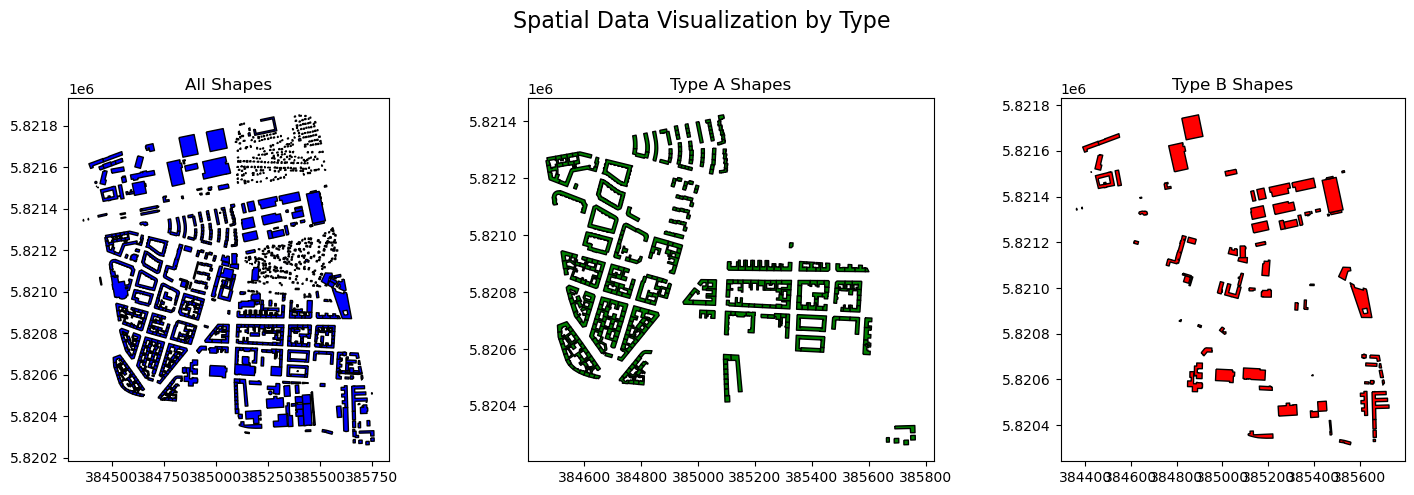

In [104]:
# Plot setup
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Horizontal layout with 3 plots

# Plot all geometries
zone_gdf.plot(ax=axs[0], color='blue', edgecolor='k')
axs[0].set_title('All Shapes')

# Plot type A
zone_gdf[zone_gdf['category'] .isin(["residential", "apartments"])].plot(ax=axs[1], color='green', edgecolor='k')
axs[1].set_title('Type A Shapes')

# Plot type B
zone_gdf[zone_gdf['category'].isin(['industrial', 'office', 'commercial', 'retail', 'warehouse', 'service', 'school', 'public', 'house', 'manufacture', 'kindergarten', 'sports_hall'])].plot(ax=axs[2], color='red', edgecolor='k')
axs[2].set_title('Type B Shapes')

# Common header
plt.suptitle('Spatial Data Visualization by Type', fontsize=16)

# Show plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the common header
plt.show()

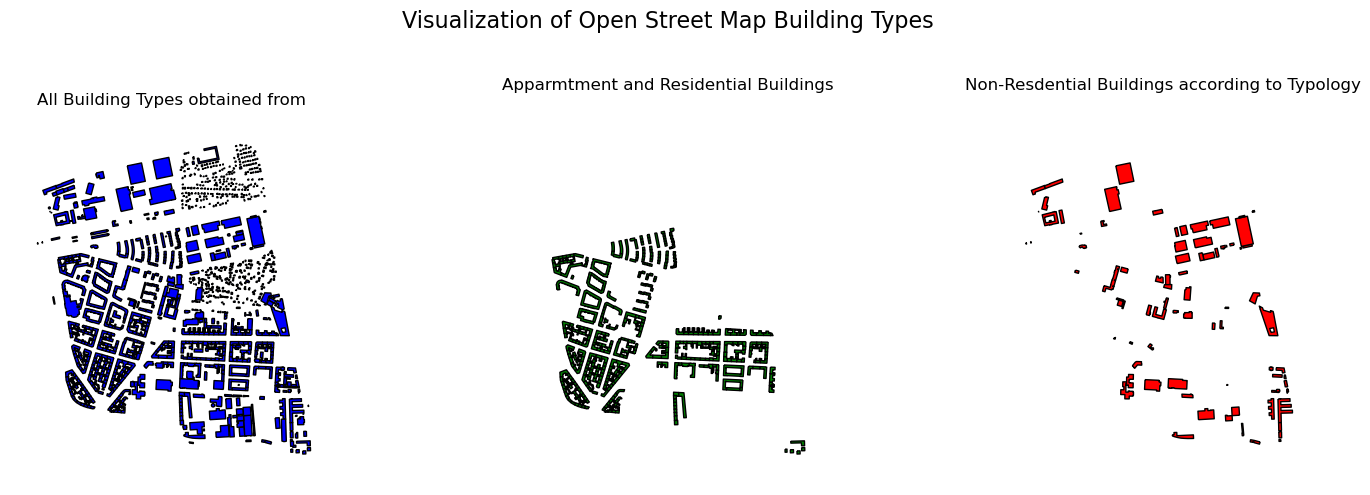

In [106]:
gdf = zone_gdf
# Calculate bounds for consistent axis limits
xmin, ymin, xmax, ymax = gdf.total_bounds  # Get the bounding box of all geometries

# Extend the bounds a bit for better visualization
xrange = xmax - xmin
yrange = ymax - ymin
xmin -= 0.1 * xrange
xmax += 0.1 * xrange
ymin -= 0.1 * yrange
ymax += 0.1 * yrange

# Plot setup
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Horizontal layout with 3 plots

# Plot all geometries
gdf.plot(ax=axs[0], color='blue', edgecolor='k')
axs[0].set_title('All Building Types obtained from ')
axs[0].set_xlim(xmin, xmax)
axs[0].set_ylim(ymin, ymax)

# Plot types A and C
gdf[gdf['category'].isin(["residential", "apartments"])].plot(ax=axs[1], color='green', edgecolor='k')
axs[1].set_title('Apparmtment and Residential Buildings')
axs[1].set_xlim(xmin, xmax)
axs[1].set_ylim(ymin, ymax)

# Plot type B
gdf[gdf['category'].isin(['industrial', 'office', 'commercial', 'retail', 'warehouse', 'service', 'school', 'public', 'house', 'manufacture', 'kindergarten', 'sports_hall'])].plot(ax=axs[2], color='red', edgecolor='k')
axs[2].set_title('Non-Resdential Buildings according to Typology')
axs[2].set_xlim(xmin, xmax)
axs[2].set_ylim(ymin, ymax)

# Remove the axis for a cleaner look and adjust for space between plots
for ax in axs:
    ax.axis('off')

# Common header
plt.suptitle('Visualization of Open Street Map Building Types', fontsize=16)

# Show plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the common header
plt.show()

In [91]:
def match_building_type( bldg_type, year):
    # This function matches building use to its archetype based on year
    try: average_year = average_year_from_range(year)
    except TypeError:
        print(year)
    year_range = find_year_range(bldg_type, average_year)
    if bldg_type in ARCHETYPES and year_range in ARCHETYPES[bldg_type]:
        return ARCHETYPES[bldg_type][year_range]
    return None


overlap["ARCHETYPE"] = overlap.apply(overlap.apply(lambda row: match_building_type(row['category'], row['ueberw_dek']), axis=1))

nan


UnboundLocalError: local variable 'average_year' referenced before assignment

In [64]:
# Create folder for modelling based on suggestions 
archetype = "ger"
year = "2020"
path_to_new_scenario = os.path.join(project_folder, 'Mierendorff_full', f'{year}_{archetype}') # create the destination path for copying the baseline scenario
path_to_baseline = os.path.join(project_folder, 'Mierendorff_full', year)
try:
    shutil.copytree(path_to_baseline, path_to_new_scenario)
except WindowsError:
    pass 

In [65]:
# map archetypes based on average year of block and building type 
archetype_path = os.path.join(project_folder, 'Mierendorff_full', f'{year}_{archetype}', "inputs", "building-properties", "typology.dbf")
archetype_file = gpd.read_file(archetype_path)
#archetype_file["STANDARD"] = archetype
archetype_file 

,Name,STANDARD,YEAR,1ST_USE,1ST_USE_R,2ND_USE,2ND_USE_R,3RD_USE,3RD_USE_R,REFERENCE,geometry
0,B1000,SFH_C,1934.0,SCHOOL,1.0,NONE,0.0,NONE,0.0,OSM - median,None
1,B1001,SFH_C,1934.0,PARKING,1.0,NONE,0.0,NONE,0.0,OSM - median,None
2,B1002,SFH_C,1934.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None
3,B1003,SFH_C,1934.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None
4,B1004,SFH_C,1934.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None
...,...,...,...,...,...,...,...,...,...,...,...
1090,B2090,SFH_C,1934.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None
1091,B2091,SFH_C,1934.0,OFFICE,1.0,NONE,0.0,NONE,0.0,OSM - median,None
1092,B2092,SFH_C,1934.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None
1093,B2093,SFH_C,1934.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None


In [ ]:

import cea.config
config = cea.config.Configuration()
config.multiprocessing = True
archetypes = ["AB_E" , "AB_E_NR", "AB_E_AR"] 
years = ["2020", "2021", "2022"]
for archetype in archetypes:
    for year in years: 
        path_to_new_scenario = os.path.join(project_folder, 'Mierendorff_full', f'{year}_{archetype}') # create the destination path for copying the baseline scenario
        path_to_baseline = os.path.join(project_folder, 'Mierendorff_full', year)
        try:
            shutil.copytree(path_to_baseline, path_to_new_scenario)
        except WindowsError:
            pass 
        archetype_path = os.path.join(project_folder, 'Mierendorff_full', f'{year}_{archetype}', "inputs", "building-properties", "typology.dbf")
        archetype_file = gpd.read_file(archetype_path)
        archetype_file["STANDARD"] = archetype
        archetype_file.to_file(archetype_path)
        config.scenario_name = f'{year}_{archetype}'
        config.archetypes_mapper.buildings = list_buildings
        archetypes_mapper(locator=cea.inputlocator.InputLocator(config.scenario), 
                      update_architecture_dbf=True, update_air_conditioning_systems_dbf=True, 
                      update_indoor_comfort_dbf=True, update_internal_loads_dbf=True,
                      update_supply_systems_dbf=True, update_schedule_operation_cea=True, 
                      buildings=list_buildings)
        config.schedule_maker.buildings = list_buildings 
        schedule_maker(config) 
        radiation_main(config)
        config.demand.buildings = list_buildings
        demand_main(config) 